In [ ]:
import asyncio
import fractions
import logging
from av import VideoFrame
from aiortc import VideoStreamTrack, RTCPeerConnection, RTCSessionDescription, MediaStreamTrack, RTCConfiguration, RTCIceServer
from aiortc.contrib.media import MediaRelay
from fastapi import FastAPI, HTTPException
from starlette.requests import Request
import cv2
import numpy as np
import pyautogui
from mss import mss
from PIL import Image
import nest_asyncio
nest_asyncio.apply()
logging.basicConfig(level=logging.DEBUG)

app = FastAPI()
relay = MediaRelay()

class ScreenCaptureTrack(VideoStreamTrack):
    kind = "video"

    def __init__(self):
        super().__init__()
        self.sct = mss()
        self.monitor = {"top": 0, "left": 0, "width": 1920, "height": 1080}
        self.fps = 30
        self.frame_time = fractions.Fraction(1, self.fps)

    async def recv(self):
        pts, time_base = await self.next_timestamp()

        sct_img = self.sct.grab(self.monitor)
        img = Image.frombytes("RGB", (sct_img.width, sct_img.height), sct_img.rgb)
        img_array = np.array(img)
        frame = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)

        video_frame = VideoFrame.from_ndarray(frame, format="bgr24")
        video_frame.pts = pts
        video_frame.time_base = time_base

        return video_frame

@app.post("/offer")
async def offer(request: Request):
    params = await request.json()
    offer = RTCSessionDescription(sdp=params["sdp"], type=params["type"])

    logging.info(f"Received offer: {offer.type}")
    logging.debug(f"Offer SDP: {offer.sdp}")

    pc = RTCPeerConnection(RTCConfiguration(iceServers=[RTCIceServer(urls=["stun:stun.l.google.com:19302"])]))

    @pc.on("connectionstatechange")
    async def on_connectionstatechange():
        logging.info(f"Connection state is {pc.connectionState}")
        if pc.connectionState == "failed":
            await pc.close()

    @pc.on("datachannel")
    def on_datachannel(channel):
        @channel.on("message")
        def on_message(message):
            logging.info(f"Received message: {message}")

    video = ScreenCaptureTrack()
    video_sender = pc.addTrack(relay.subscribe(video))

    logging.info("Setting remote description")
    await pc.setRemoteDescription(offer)

    logging.info("Creating answer")
    answer = await pc.createAnswer()

    logging.info("Setting local description")
    try:
        await pc.setLocalDescription(answer)
    except Exception as e:
        logging.error(f"Error setting local description: {e}")
        logging.debug(f"Answer SDP: {answer.sdp}")
        raise HTTPException(status_code=500, detail=str(e))

    logging.info("Local description set successfully")
    logging.debug(f"Answer SDP: {pc.localDescription.sdp}")

    return {"sdp": pc.localDescription.sdp, "type": pc.localDescription.type}

if __name__ == "__main__":
    import uvicorn
    uvicorn.run(app, host="0.0.0.0", port=3000)

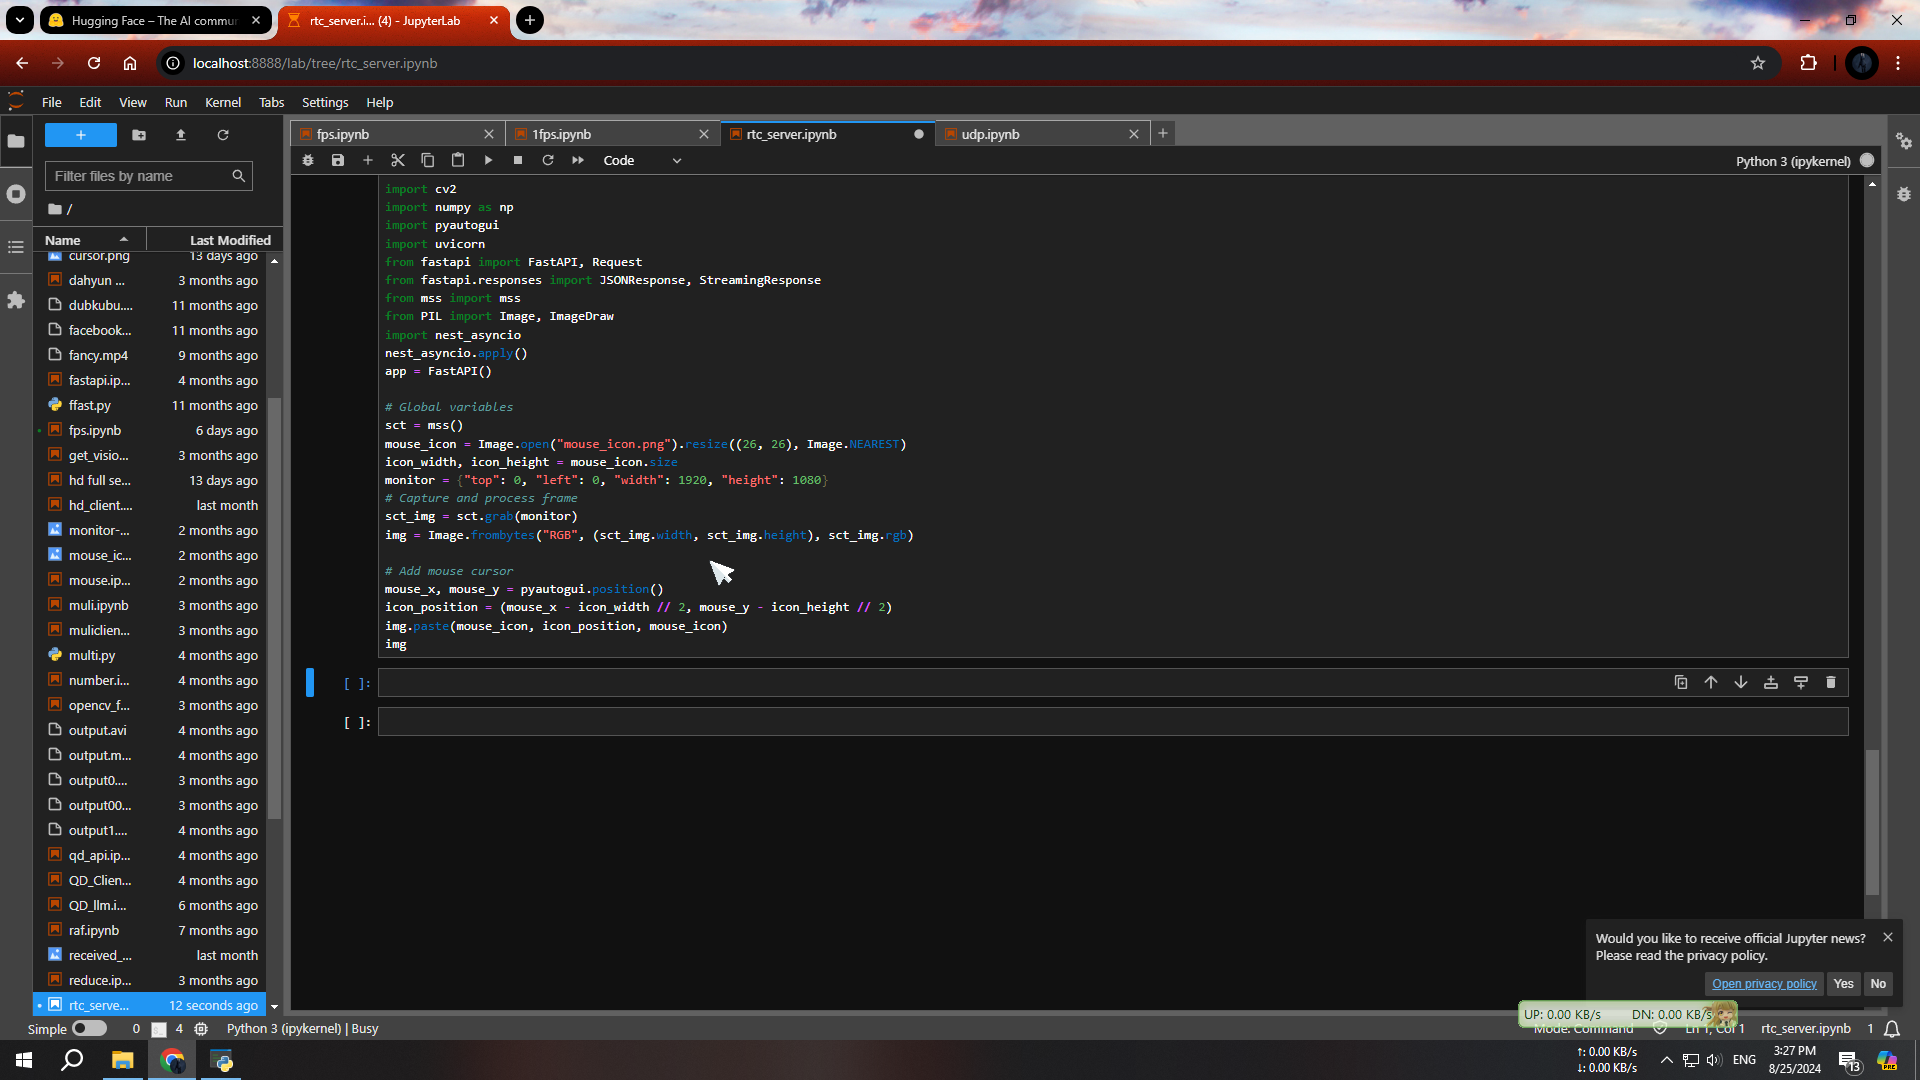

In [1]:
import asyncio
import io
import time
from typing import Generator

import cv2
import numpy as np
import pyautogui
import uvicorn
from fastapi import FastAPI, Request
from fastapi.responses import JSONResponse, StreamingResponse
from mss import mss
from PIL import Image, ImageDraw
import nest_asyncio
nest_asyncio.apply()
app = FastAPI()

# Global variables
sct = mss()
mouse_icon = Image.open("mouse_icon.png").resize((26, 26), Image.NEAREST)
icon_width, icon_height = mouse_icon.size
monitor = {"top": 0, "left": 0, "width": 1920, "height": 1080}
# Capture and process frame
sct_img = sct.grab(monitor)
img = Image.frombytes("RGB", (sct_img.width, sct_img.height), sct_img.rgb)

# Add mouse cursor
mouse_x, mouse_y = pyautogui.position()
icon_position = (mouse_x - icon_width // 2, mouse_y - icon_height // 2)
img.paste(mouse_icon, icon_position, mouse_icon)
img

In [ ]:
import io
from fastapi import FastAPI, Response
from mss import mss
from PIL import Image
import pyautogui
import uvicorn
import nest_asyncio

nest_asyncio.apply()
app = FastAPI()

# Global variables
sct = mss()
mouse_icon = Image.open("mouse_icon.png").resize((26, 26), Image.NEAREST)
icon_width, icon_height = mouse_icon.size
monitor = {"top": 0, "left": 0, "width": 1920, "height": 1080}

def capture_screenshot():
    # Capture the screen
    sct_img = sct.grab(monitor)
    img = Image.frombytes("RGB", (sct_img.width, sct_img.height), sct_img.rgb)
    
    # Get the current mouse position
    mouse_x, mouse_y = pyautogui.position()
    
    # Calculate mouse icon position
    icon_position = (mouse_x - icon_width // 2, mouse_y - icon_height // 2)
    
    # Paste the mouse icon onto the screenshot
    img.paste(mouse_icon, icon_position, mouse_icon)
    
    return img

@app.get("/screenshot")
async def get_screenshot():
    img = capture_screenshot()
    
    # Convert the image to JPEG format to reduce size
    img_byte_arr = io.BytesIO()
    img.save(img_byte_arr, format='JPEG', quality=70)  # Reduced quality for speed
    img_byte_arr.seek(0)
    
    # Return the image as a response
    return Response(content=img_byte_arr.getvalue(), media_type="image/jpeg")

if __name__ == "__main__":
    uvicorn.run(app, host="0.0.0.0", port=3000)


INFO:     Started server process [15024]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://0.0.0.0:3000 (Press CTRL+C to quit)


INFO:     34.168.129.111:0 - "GET /screenshot HTTP/1.1" 200 OK
